In [31]:
from GP_recovery import *

In [59]:
Nr = 1
t = np.linspace(0, 700*2, 1401)
gp = GaussianProcess(kernel, t)
y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))
y = y[0,:]
t.shape, y.shape

((1401,), (1401,))

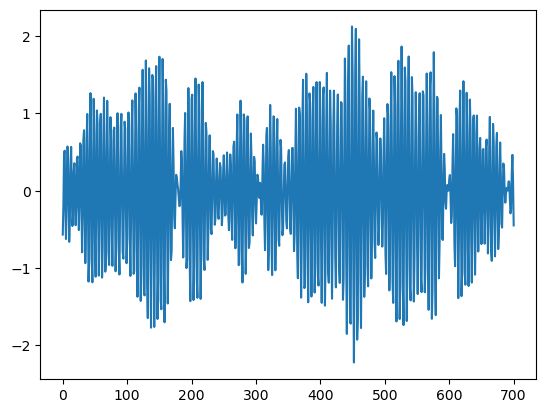

In [30]:
plt.plot(t, y)

In [3]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -1007.2208452431912
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-173.80210192, dtype=float64)}


### Performance

### Q

In [48]:
def solve():
    w_init = jnp.zeros(len(theta_init))
    lower_bounds = jnp.ones_like(w_init)* (-1)
    upper_bounds = jnp.ones_like(w_init) * jnp.inf
    bounds = (lower_bounds, upper_bounds)

    import jaxopt
    solver = jaxopt.ScipyMinimize(method='BFGS', fun=neg_log_likelihood, maxiter=1000)
    soln = solver.run(theta_init, X=t, y=y)
    # soln = solver.run(theta_init, bounds=bounds, X=t, y=y)
    print(f"Final negative log likelihood: {soln.state.fun_val}")

    for key, value in soln.params.items():
        print(key[4:], np.exp(value))
    
    model_gp, _ = build_gp(soln.params, t)
    
    fig = plt.figure(figsize=(16, 6))
    plt.plot(t, kernel(t, t[:1]), lw=1, color='k', alpha=0.8, label='true kernel')
    plt.plot(t, model_gp.kernel(t, t[:1]), lw=2, color='r', alpha=0.5, label='recovered kernel')
    plt.title('Kernels')
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.legend()
    plt.show()

Final negative log likelihood: -1080.8893340261754
A1 0.22509863231824148
A2 0.2530779847558798
A3 0.46518145269597166
A4 0.37422927674933076
A5 0.31705879947080917
A6 0.1437134517683729
A7 0.3079566352720176
Q 443.8411689725718
delta_nu 133.80592424281662
nu_max 3081.0230062962637


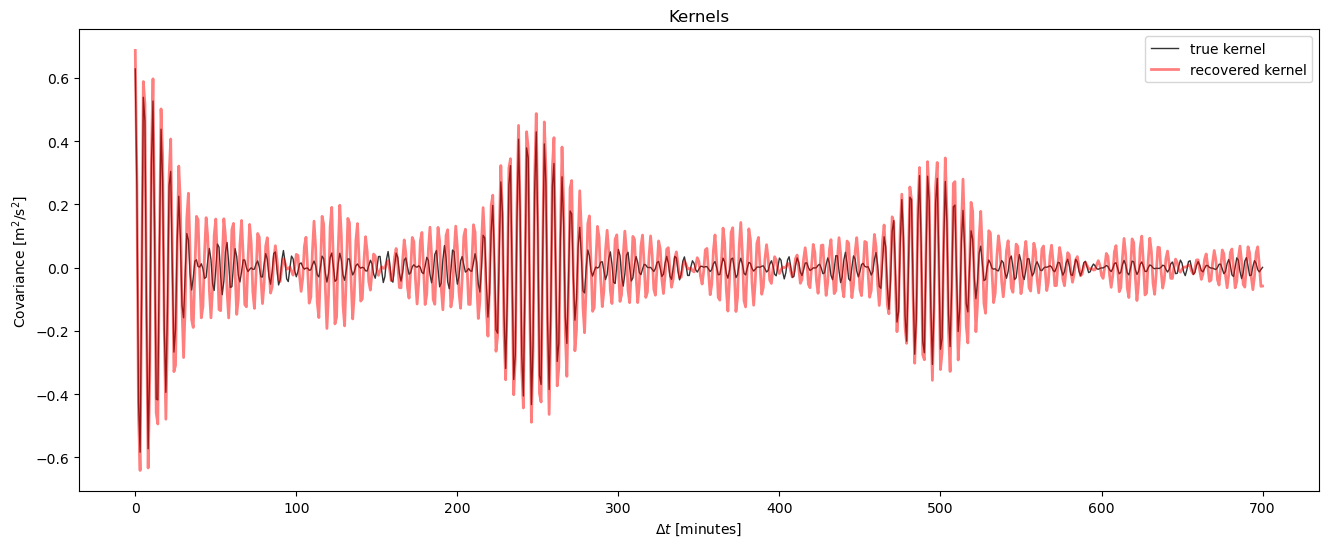

In [49]:
 solve()

### Q, delta_nu

In [36]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(400),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(135),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

Initial negative log likelihood: -1077.2535543179956
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-9.15838406, dtype=float64), 'log_delta_nu': DeviceArray(76.17070256, dtype=float64)}


Final negative log likelihood: -1077.855995076333
Q 412.4199453996841
delta_nu 133.39000989068103


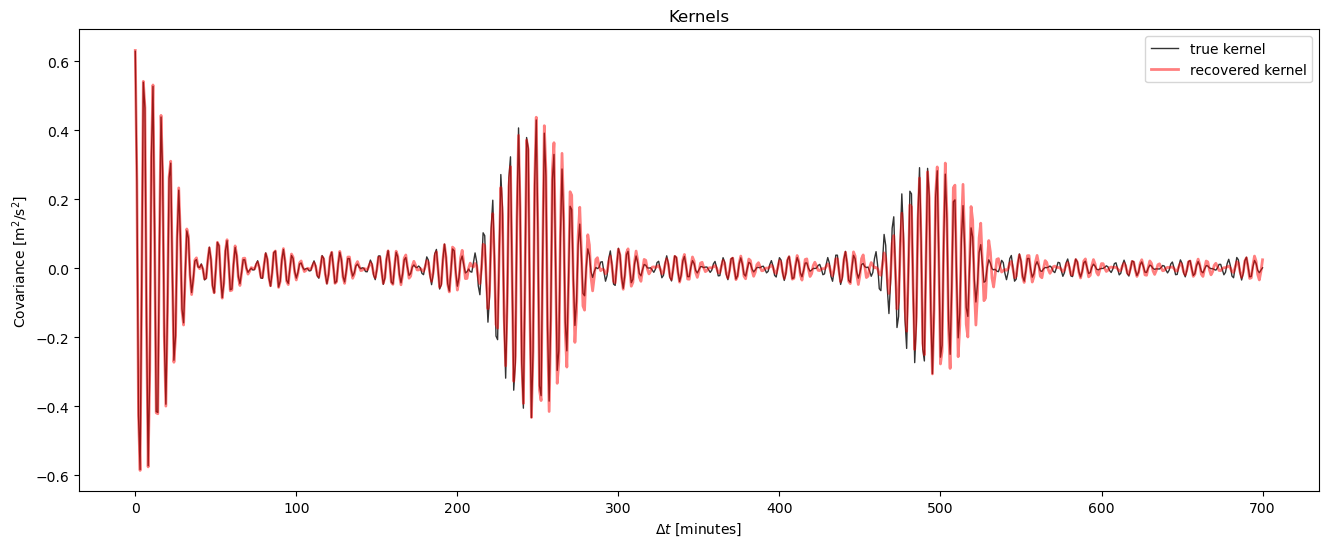

In [37]:
solve()

### Q, nu_max

Initial negative log likelihood: -885.5416490647797
Gradient of the negative log likelihood, wrt the parameters:
{'log_Q': DeviceArray(-26.82330104, dtype=float64), 'log_nu_max': DeviceArray(-9843.83119739, dtype=float64)}
Final negative log likelihood: -1077.3813872241194
Q 411.05431407040675
nu_max 3080.702708158807


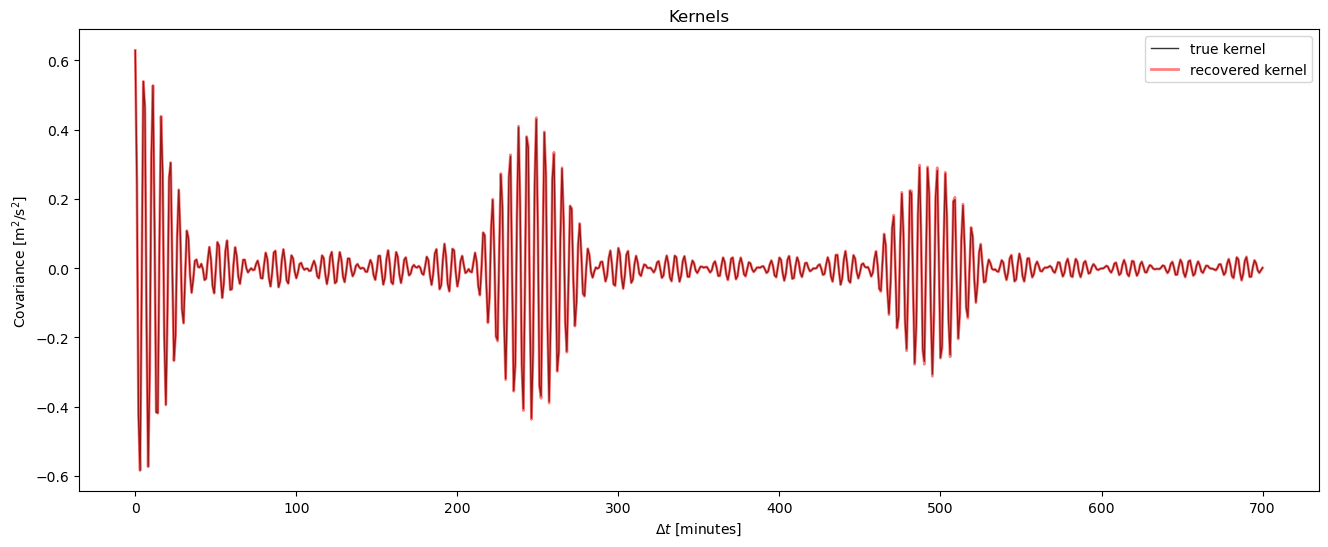

In [10]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    # A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    # "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A

Initial negative log likelihood: -402.9035692650816
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-1881.69162911, dtype=float64), 'log_Q': DeviceArray(897.80398721, dtype=float64), 'log_nu_max': DeviceArray(-41869.81120253, dtype=float64)}
Final negative log likelihood: -1077.3704030491563
A 0.3678794411714424
Q 516.5902234708506
nu_max 3080.6772175751507


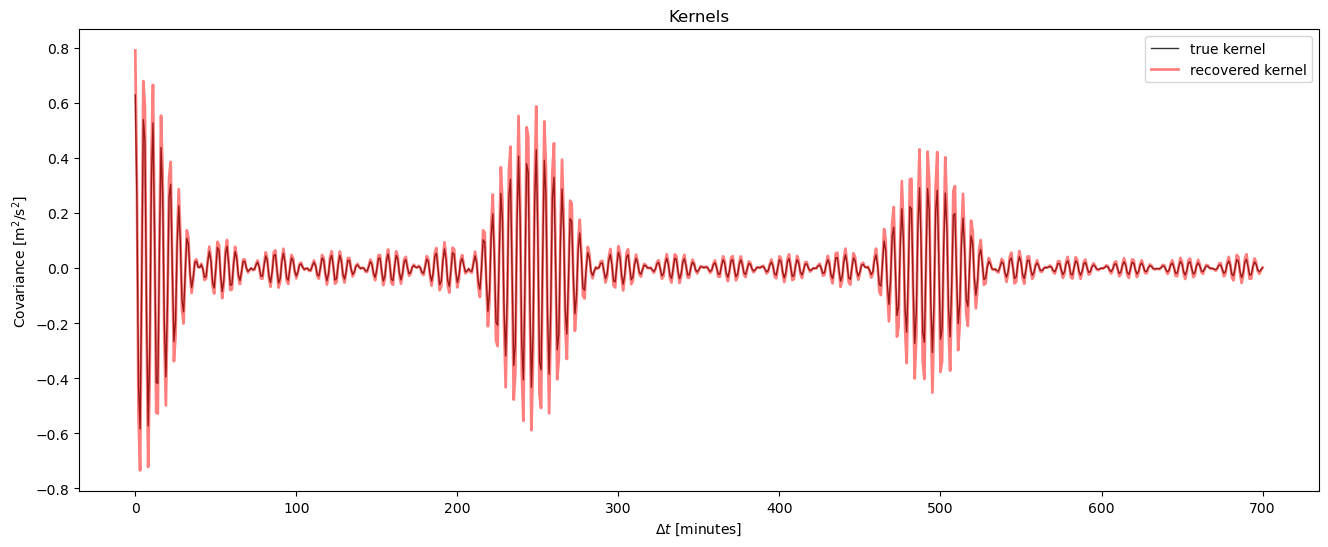

In [11]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [34]:
amp

0.3281255832

In [12]:
amp

0.3281255832

### Q, nu_max, A, delta_nu

Initial negative log likelihood: -449.806532120841
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-1792.34464536, dtype=float64), 'log_Q': DeviceArray(851.73723983, dtype=float64), 'log_delta_nu': DeviceArray(-1319.75161876, dtype=float64), 'log_nu_max': DeviceArray(-41001.95551194, dtype=float64)}
Final negative log likelihood: -1077.840655186698
A 0.3678794411714424
Q 518.3873195587042
delta_nu 133.3774919737948
nu_max 3081.0144044590784


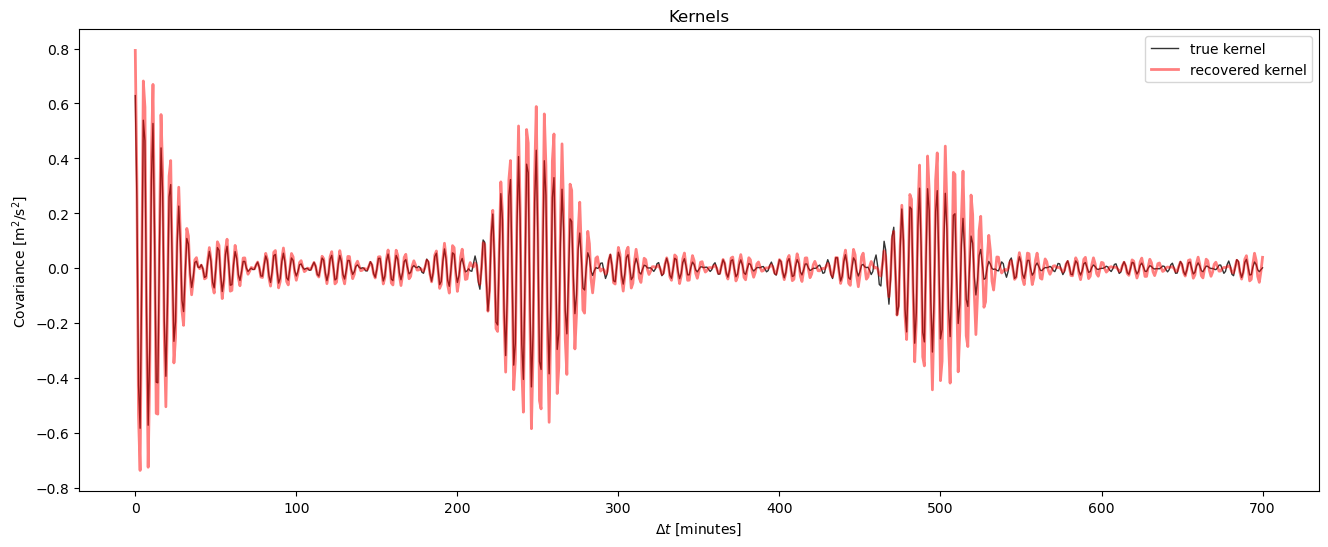

In [13]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    # # "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W

Initial negative log likelihood: -441.51129368880447
Gradient of the negative log likelihood, wrt the parameters:
{'log_A': DeviceArray(-1813.73394852, dtype=float64), 'log_Q': DeviceArray(862.08481997, dtype=float64), 'log_W': DeviceArray(-477.81613515, dtype=float64), 'log_delta_nu': DeviceArray(-1317.11512448, dtype=float64), 'log_nu_max': DeviceArray(-41366.91654997, dtype=float64)}
Final negative log likelihood: -1078.0884655343307
A 0.37096110832792345
Q 472.7675047340585
W 237.02045863071214
delta_nu 133.55408237403827
nu_max 3081.133684383088


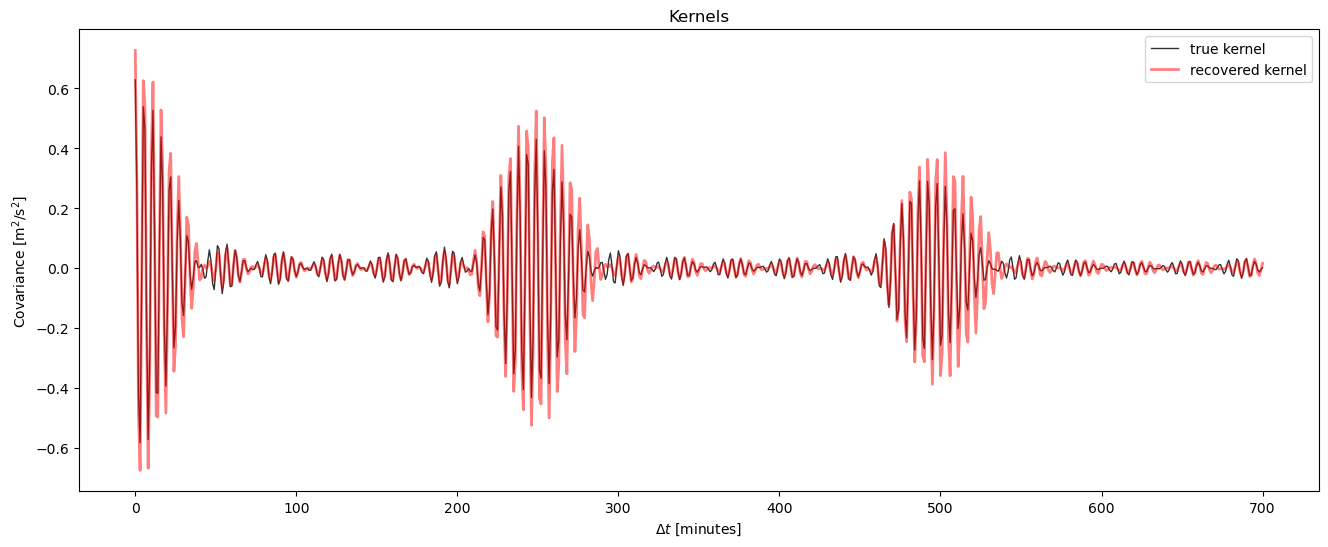

In [14]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Q, nu_max, A, delta_nu, W, epsilon

Initial negative log likelihood: -441.51129368880447
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-11.9877394, dtype=float64), 'log_A': DeviceArray(-1813.73394852, dtype=float64), 'log_Q': DeviceArray(862.08481997, dtype=float64), 'log_W': DeviceArray(-477.81613515, dtype=float64), 'log_delta_nu': DeviceArray(-1317.11512448, dtype=float64), 'log_nu_max': DeviceArray(-41366.91654997, dtype=float64)}
Final negative log likelihood: -1078.0884656008152
lon 1.0001760208832151
A 0.3709646856227132
Q 472.8016713562955
W 237.04100430572703
delta_nu 133.5537768521377
nu_max 3081.1331633904315


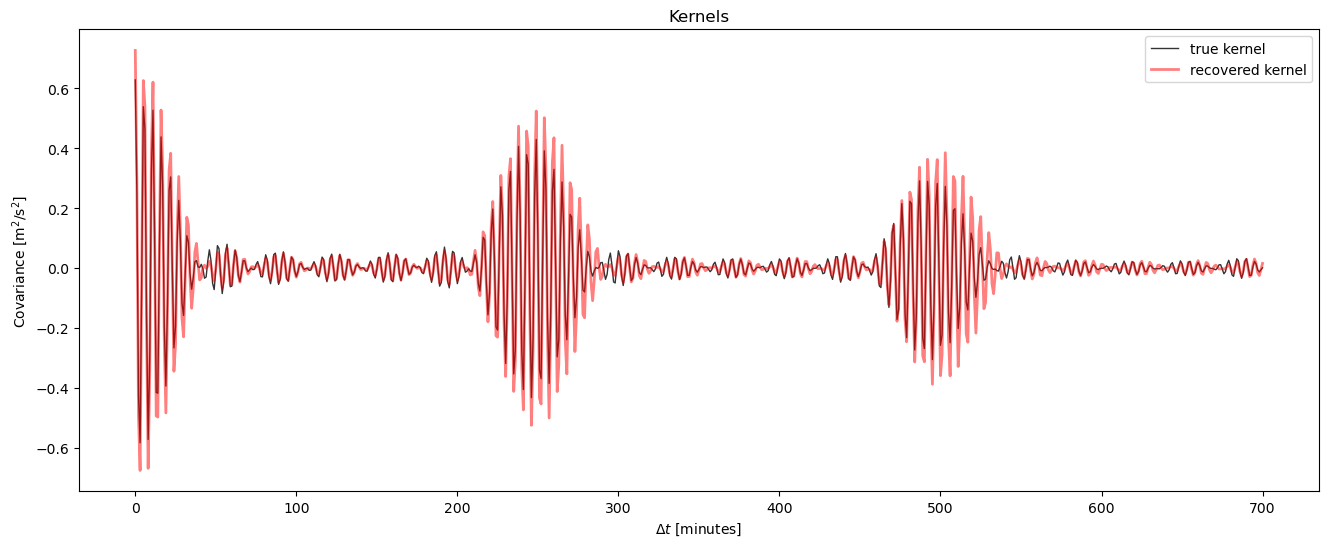

In [16]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### +diag

Initial negative log likelihood: 599.2463496121363
Gradient of the negative log likelihood, wrt the parameters:
{'epsilon': DeviceArray(-2.19079363, dtype=float64), 'log_A': DeviceArray(-104.52758409, dtype=float64), 'log_Q': DeviceArray(30.38684337, dtype=float64), 'log_W': DeviceArray(-15.33899602, dtype=float64), 'log_delta_nu': DeviceArray(-3.92926598, dtype=float64), 'log_diag': DeviceArray(242.4420831, dtype=float64), 'log_nu_max': DeviceArray(-6821.82963315, dtype=float64)}
Final negative log likelihood: 421.67003288930715
lon 1.0998779723472647
A 0.3678794411714424
Q 334.39804228767065
W 1190.343787017255
delta_nu 133.9062946866547
diag 0.3678794411714424
nu_max 3144.378147750694


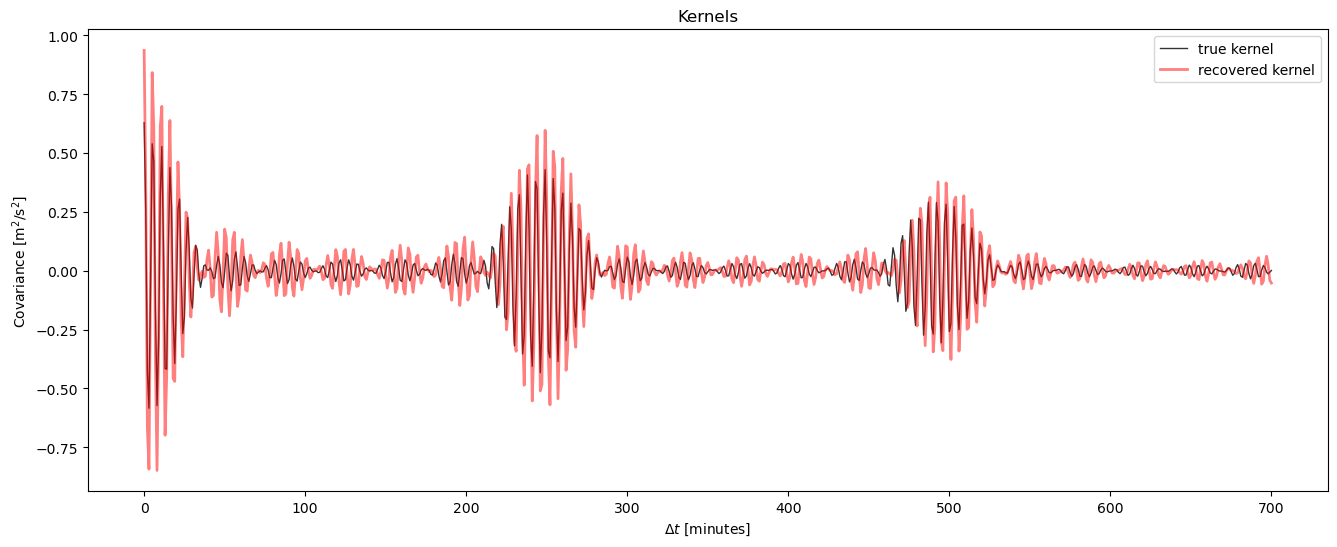

In [18]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    A = jnp.exp(theta["log_A"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    W = jnp.exp(theta["log_W"])
    epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(N):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, A, nu_max, W) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)

    return GaussianProcess(
        kernel, X, diag=jnp.exp(theta["log_diag"])), kernel           

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A": np.log(0.5*amp),
    "log_W": np.log(300),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140),
    "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### individual

Initial negative log likelihood: 13805.555417214113
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-31645.55265191, dtype=float64), 'log_Q': DeviceArray(15762.5827781, dtype=float64), 'log_nu1': DeviceArray(-309054.06621481, dtype=float64)}
Final negative log likelihood: -781.6296041353646
A1 0.7715034037950126
Q 138.96470208704739
nu1 3092.7163501126774


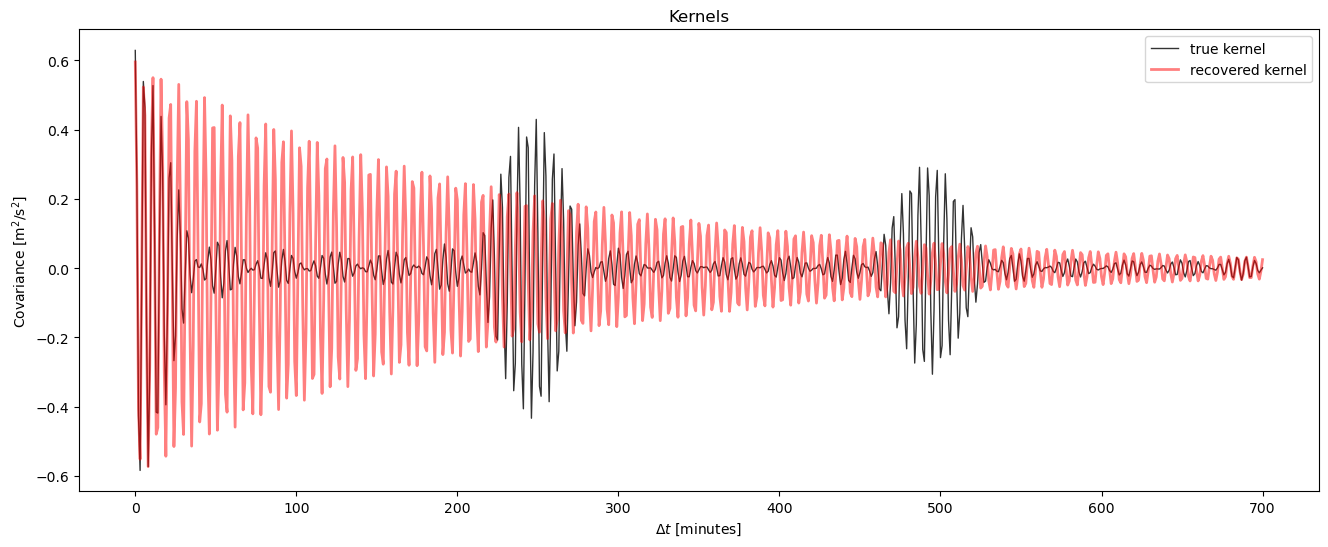

In [38]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu1 = jnp.exp(theta["log_nu1"])
    
    # nu_max = jnp.exp(theta["log_nu_max"])
    A1 = jnp.exp(theta["log_A1"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    for i in range(1):
        omega = 2*np.pi*nu1*uHz_conv
        sigma = A1
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(200),
    "log_A1": np.log(0.5*amp),
    "log_nu1": np.log(3000),
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### Individual 2

Initial negative log likelihood: -102.91220642871531
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-1438.65566943, dtype=float64), 'log_A2': DeviceArray(-1311.78067635, dtype=float64), 'log_Q': DeviceArray(1370.26218366, dtype=float64), 'log_nu1': DeviceArray(-7355.3286966, dtype=float64), 'log_nu2': DeviceArray(-21187.63874037, dtype=float64)}
Final negative log likelihood: -974.881065952221
A1 0.9606609566549282
A2 0.3678794411714424
Q 450.88311631257386
nu1 3025.7068962534895
nu2 3274.7299054252103


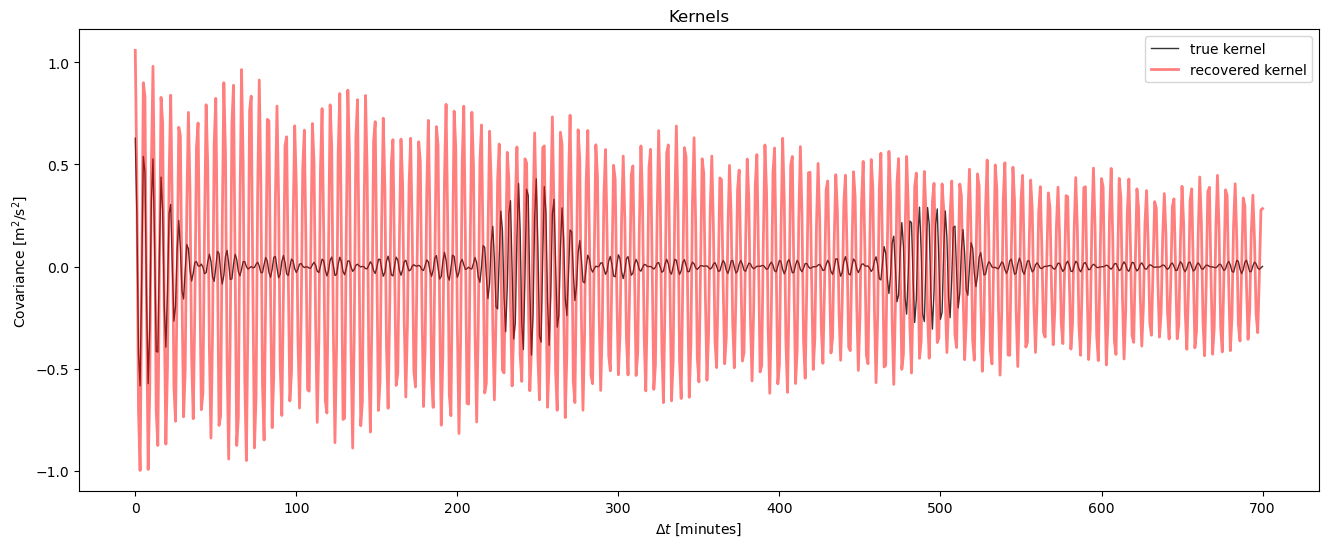

In [40]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu1 = jnp.exp(theta["log_nu1"])
    nu2 = jnp.exp(theta["log_nu2"])
    # nu_max = jnp.exp(theta["log_nu_max"])
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    # delta_nu = jnp.exp(theta["log_delta_nu"])
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    kernel += tinygp.kernels.quasisep.SHO(2*np.pi*nu1*uHz_conv, Q, A1)
    kernel += tinygp.kernels.quasisep.SHO(2*np.pi*nu2*uHz_conv, Q, A2)
            
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(400),
    "log_A1": np.log(1.1*amp),
    "log_nu1": np.log(3000),
    "log_A2": np.log(0.9*amp),
    "log_nu2": np.log(3200),    
    # "log_W": np.log(300),
    # "log_nu_max": np.log(3000),
    # "log_delta_nu": np.log(140),
    # "epsilon": np.float64(0.0)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

### 7 modes

Initial negative log likelihood: -925.8977595391348
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(28.51807567, dtype=float64), 'log_A2': DeviceArray(24.12121109, dtype=float64), 'log_A3': DeviceArray(28.93010757, dtype=float64), 'log_A4': DeviceArray(21.03470934, dtype=float64), 'log_A5': DeviceArray(28.46183055, dtype=float64), 'log_A6': DeviceArray(12.24002051, dtype=float64), 'log_A7': DeviceArray(-83.8546067, dtype=float64), 'log_Q': DeviceArray(-25.41103788, dtype=float64), 'log_delta_nu': DeviceArray(-366.58675619, dtype=float64), 'log_nu_max': DeviceArray(-9582.41326018, dtype=float64)}
Final negative log likelihood: -1077.76498265781
A1 0.3678794411714424
A2 0.3678794411714424
A3 0.5338991871585221
A4 0.46842607955602333
A5 0.3678794411714424
A6 0.3678794411714424
A7 0.3678794411714424
Q 767.1990503437163
delta_nu 133.51240869596737
nu_max 3080.714578356499


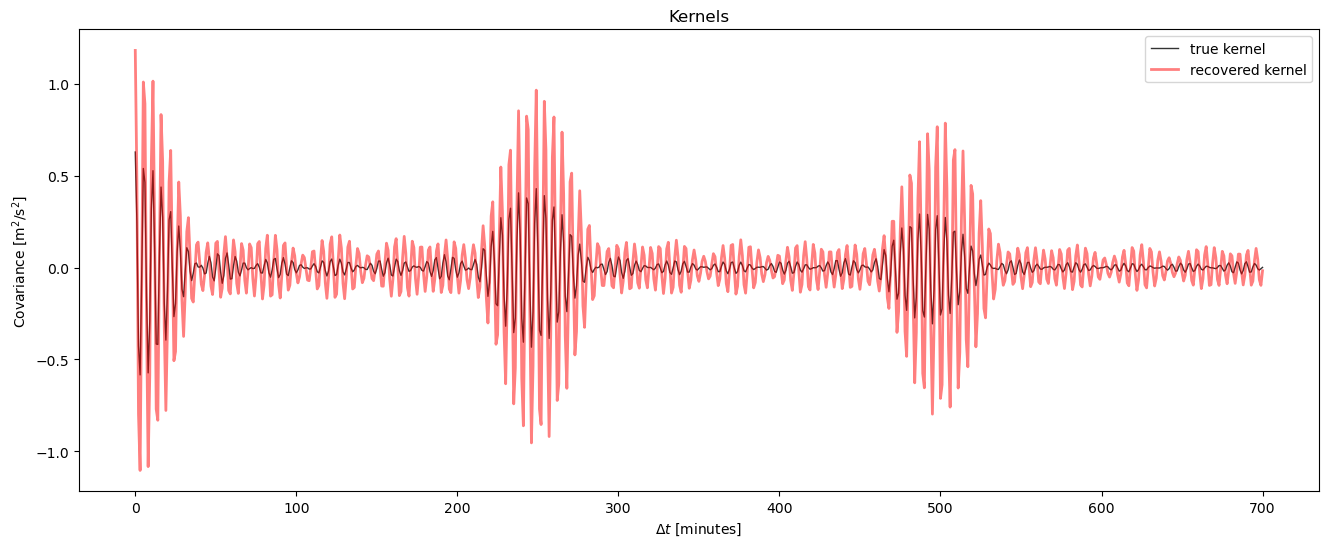

In [42]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = jnp.exp(theta["log_delta_nu"])
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(300),
    "log_A1": np.log(0.8*amp),
    "log_A2": np.log(0.9*amp),
    "log_A3": np.log(1*amp),
    "log_A4": np.log(1.1*amp),
    "log_A5": np.log(1.2*amp),
    "log_A6": np.log(1.15*amp),
    "log_A7": np.log(1.05*amp),
    "log_nu_max": np.log(3000),
    "log_delta_nu": np.log(140)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [41]:
for i in range(N):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    # kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595


### 9 modes

Initial negative log likelihood: -2034.835850891038
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(5.5751085, dtype=float64), 'log_A2': DeviceArray(-2.74103556, dtype=float64), 'log_A3': DeviceArray(-61.60091726, dtype=float64), 'log_A4': DeviceArray(-7.7241625, dtype=float64), 'log_A5': DeviceArray(-80.10570401, dtype=float64), 'log_A6': DeviceArray(4.42742802, dtype=float64), 'log_A7': DeviceArray(17.09080498, dtype=float64), 'log_A8': DeviceArray(23.84465993, dtype=float64), 'log_A9': DeviceArray(32.75325157, dtype=float64)}
Final negative log likelihood: -2176.267858760456
A1 0.27448049181190265
A2 0.32101400898620375
A3 0.277661448191899
A4 0.3306990074714089
A5 0.3646608011679721
A6 0.2232553498217135
A7 0.2480038927278273
A8 0.018557799230346464
A9 2.6203635907672065e-07


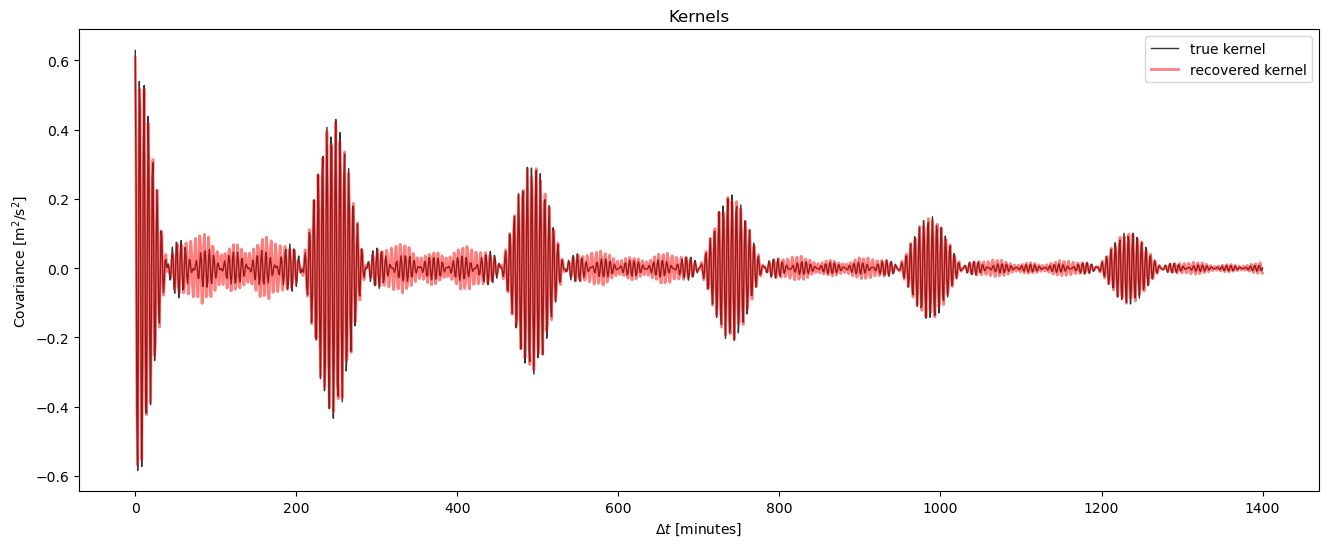

In [61]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = 400
    nu_max = 3080
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = 135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    # "log_Q": np.log(400),
    "log_A1": np.log(0.26),
    "log_A2": np.log(0.30),
    "log_A3": np.log(0.32),
    "log_A4": np.log(0.01),
    "log_A5": np.log(0.32),
    "log_A6": np.log(0.30),
    "log_A7": np.log(0.26),
    "log_A8": np.log(0.26),
    "log_A9": np.log(0.26),
    # "log_nu_max": np.log(3080),
    # "log_delta_nu": np.log(135)
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

In [51]:
for i in range(N):
    omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
    sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
    # kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
    print(sigma)

0.26336135786308595
0.29757809812482694
0.3202066230161938
0.3281255832
0.3202066230161938
0.29757809812482694
0.26336135786308595


### fix delta_nu

In [60]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = jnp.exp(theta["log_Q"])
    nu_max = jnp.exp(theta["log_nu_max"])
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = 135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    "log_Q": np.log(300),
    "log_A1": np.log(0.5*amp),
    "log_A2": np.log(0.5*amp),
    "log_A3": np.log(0.5*amp),
    "log_A4": np.log(0.5*amp),
    "log_A5": np.log(0.5*amp),
    "log_A6": np.log(0.5*amp),
    "log_A7": np.log(0.5*amp),
    "log_A8": np.log(0.5*amp),
    "log_A9": np.log(0.5*amp),
    "log_nu_max": np.log(3000),
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()

KeyboardInterrupt: 

### Fix Q

Initial negative log likelihood: -752.5587683168125
Gradient of the negative log likelihood, wrt the parameters:
{'log_A1': DeviceArray(-86.37952866, dtype=float64), 'log_A2': DeviceArray(-112.07454072, dtype=float64), 'log_A3': DeviceArray(-113.2722686, dtype=float64), 'log_A4': DeviceArray(-194.09650552, dtype=float64), 'log_A5': DeviceArray(-164.37315329, dtype=float64), 'log_A6': DeviceArray(-138.80290263, dtype=float64), 'log_A7': DeviceArray(-161.91392116, dtype=float64), 'log_A8': DeviceArray(-80.32716655, dtype=float64), 'log_A9': DeviceArray(-234.20007333, dtype=float64), 'log_nu_max': DeviceArray(-29777.61591287, dtype=float64)}
Final negative log likelihood: -994.7154617407957
A1 0.3678794411714424
A2 0.3678794411714424
A3 0.3678794411714424
A4 0.3678794411714424
A5 0.3678794411714424
A6 0.3678794411714424
A7 0.3678794411714424
A8 0.3678794411714424
A9 0.3678794411714424
nu_max 3012.9565454758977


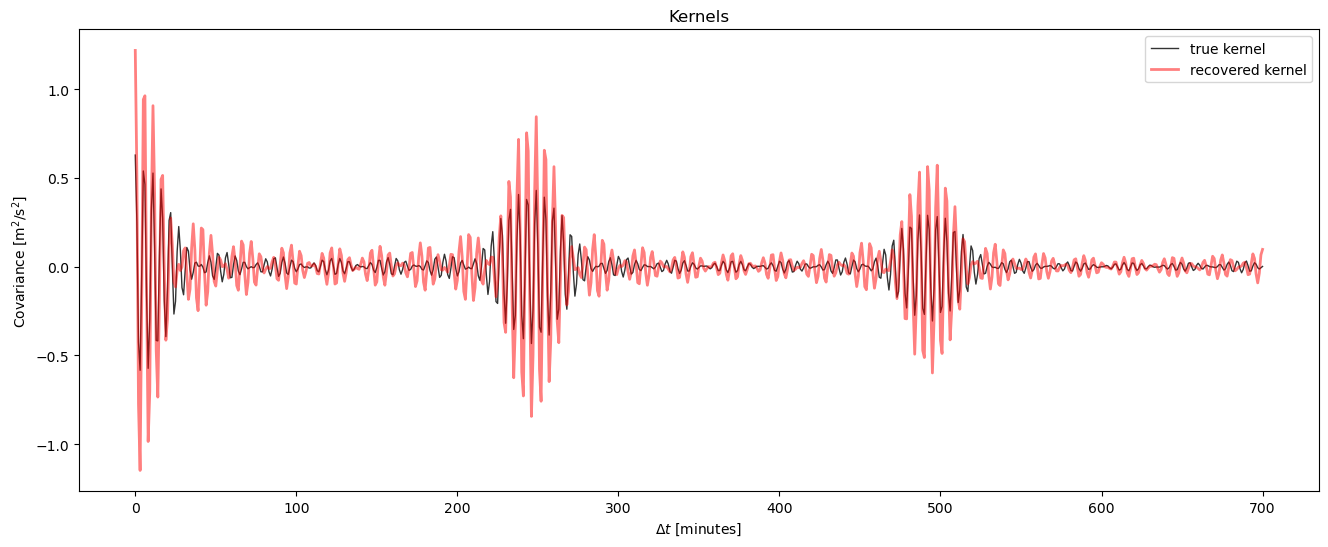

In [29]:
def build_gp(theta, X):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    Q = 400
    nu_max = jnp.exp(theta["log_nu_max"])
    
    A1 = jnp.exp(theta["log_A1"])
    A2 = jnp.exp(theta["log_A2"])
    A3 = jnp.exp(theta["log_A3"])
    A4 = jnp.exp(theta["log_A4"])
    A5 = jnp.exp(theta["log_A5"])
    A6 = jnp.exp(theta["log_A6"])
    A7 = jnp.exp(theta["log_A7"])
    A8 = jnp.exp(theta["log_A8"])
    A9 = jnp.exp(theta["log_A9"])    
    # A3 = jnp.exp(theta["log_A3"])
    delta_nu = 135
    # W = jnp.exp(theta["log_W"])
    # epsilon = theta["epsilon"]

    kernel = 0     
    omega = 2*np.pi*(nu_max + (-3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A1)
    omega = 2*np.pi*(nu_max + (-2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A2)
    omega = 2*np.pi*(nu_max + (-1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A3)
    omega = 2*np.pi*(nu_max + (0)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A4)
    omega = 2*np.pi*(nu_max + (1)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A5)
    omega = 2*np.pi*(nu_max + (2)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A6)
    omega = 2*np.pi*(nu_max + (3)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A7)
    omega = 2*np.pi*(nu_max + (-4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A8)    
    omega = 2*np.pi*(nu_max + (4)*delta_nu/2 + epsilon)*uHz_conv
    kernel += tinygp.kernels.quasisep.SHO(omega, Q, A9)    
    
    return GaussianProcess(kernel, X), kernel

def neg_log_likelihood(theta, X, y):
    gp, _ = build_gp(theta, X)
    return -gp.log_probability(y)


theta_init = {
    # "log_diag": np.log(0.5),
    # "log_Q": np.log(300),
    "log_A1": np.log(0.5*amp),
    "log_A2": np.log(0.5*amp),
    "log_A3": np.log(0.5*amp),
    "log_A4": np.log(0.5*amp),
    "log_A5": np.log(0.5*amp),
    "log_A6": np.log(0.5*amp),
    "log_A7": np.log(0.5*amp),
    "log_A8": np.log(0.5*amp),
    "log_A9": np.log(0.5*amp),
    "log_nu_max": np.log(3000),
}


# `jax` can be used to differentiate functions, and also note that we're calling
# `jax.jit` for the best performance.
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")
print(
    f"Gradient of the negative log likelihood, wrt the parameters:\n{obj(theta_init, t, y)[1]}"
)

solve()